<a href="https://colab.research.google.com/github/davidovg/Trading-Ideas/blob/main/HMM_impelemntation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime,timedelta
#from yahoo_fin import options
import seaborn as sns
yf.pdr_override()
from scipy.stats import skew, kurtosis, norm

## Step 1

In our study we use timeseries of ICE European Union Allowance Futures Contract which is available on Reuters or at Investing.com. A European Union Allowance (EUA) is the official name for Europe’s emission allowances, which in 2008 was defined as the official Kyoto allowance for countries in the EU. One EUA entitles the holder to emit one ton of carbon dioxide or carbon-equivalent greenhouse gas. We have chosen this timeseries because of the rise in ESG and climate change awareness after Covid which led to the increasing importance of carbon trading in the financial markets.


In [2]:
data = pd.read_excel('Carbon_Data.xlsx')
data = data.set_index('Date')

In [3]:
data.head()

,EEX-EU CO2 Emissions E/EUA - SETT. PRICE,DAX PERFORMANCE - PRICE INDEX
Date,,
2019-01-01,24.63,13249.01
2019-01-02,25.02,13249.01
2019-01-03,23.04,13385.93
2019-01-04,23.49,13219.14
2019-01-07,22.07,13126.99


In [4]:
data = data.rename(columns={
    'EEX-EU CO2 Emissions E/EUA - SETT. PRICE': 'CO2',
    'DAX PERFORMANCE - PRICE INDEX': 'DAX'
})

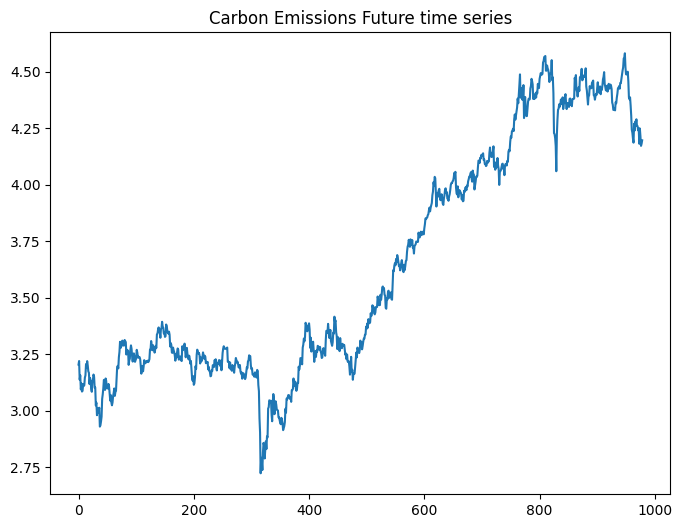

In [5]:
YDatapd = data[['CO2']]
YData = YDatapd.to_numpy()
YData = np.log(YData)
plt.plot(YData)
plt.title("Carbon Emissions Future time series")

fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

In [6]:
data_ret = data.pct_change()

## Step 2 a) Identify Regime Changes

In [9]:
Q1 = data['CO2'].quantile(0.25)
Q3 = data['CO2'].quantile(0.75)
# Define the quantile intervals and labels
quantile_intervals = [float('-inf'), Q1, Q3, float('inf')]
labels = [1, 2, 3]

data['Quantile Labels'] = pd.cut(data['CO2'], bins=quantile_intervals, labels=labels, include_lowest=True)


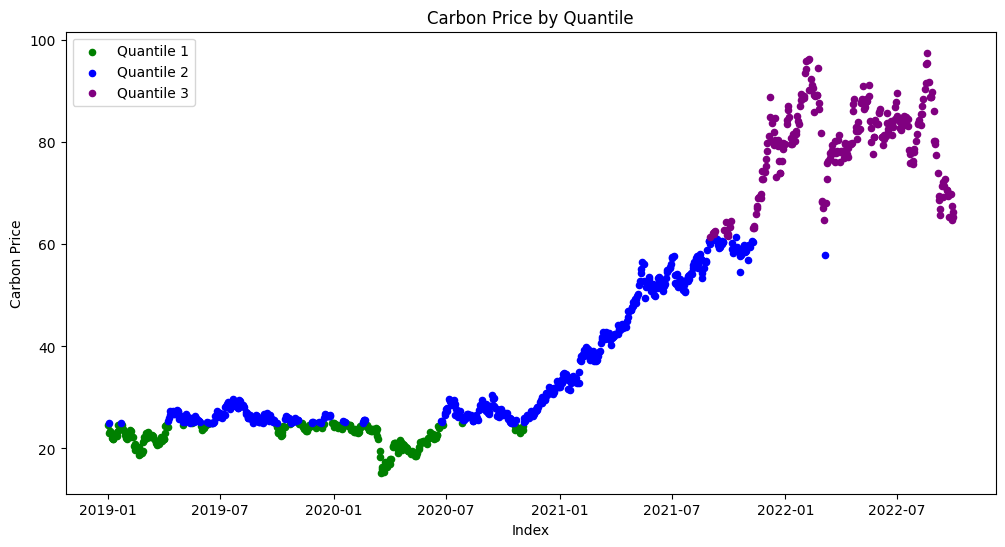

In [10]:
#colors for each quantile label
quantile_colors = ['green', 'blue', 'purple']

quantile_legend_mapping = {}
for label, color in zip(data['Quantile Labels'].unique(), quantile_colors):
    quantile_legend_mapping[f'Quantile {label}'] = color

plt.figure(figsize=(12, 6))

for label, color in quantile_legend_mapping.items():
    label_data = data[data['Quantile Labels'] == int(label.split()[1])]
    plt.scatter(label_data.index, label_data['CO2'], s=20, marker='o', label=label, color=color)

# Sort legend entries based on quantile label names
sorted_legend = [label for label, _ in sorted(quantile_legend_mapping.items(), key=lambda x: int(x[0].split()[1]))]
plt.legend(sorted_legend)

plt.title('Carbon Price by Quantile')
plt.xlabel('Index')
plt.ylabel('Carbon Price')
plt.show()

We can clearly notice 3 regimes in the timeseries.

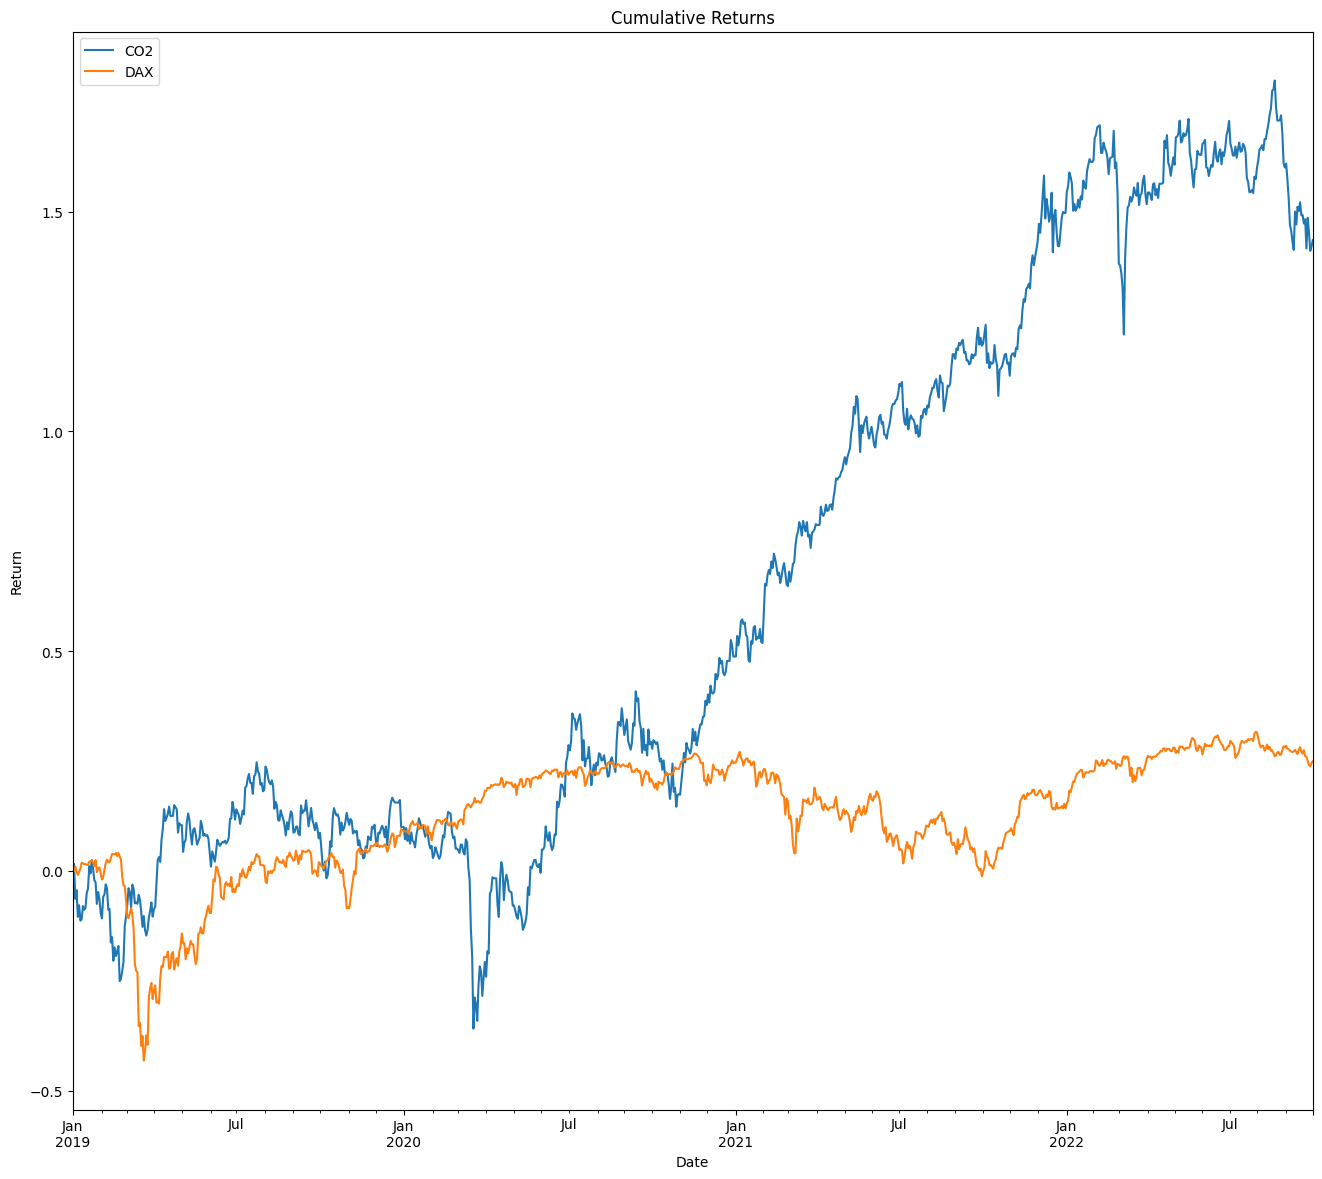

In [11]:
cumulative_returns = data_ret.cumsum()
# Plotting the normalized data
cumulative_returns.plot(figsize=(16, 14), title='Cumulative Returns', xlabel='Date', ylabel='Return', legend=True)
plt.show()

In [12]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [13]:
data_norm = feature_normalize(data_ret)

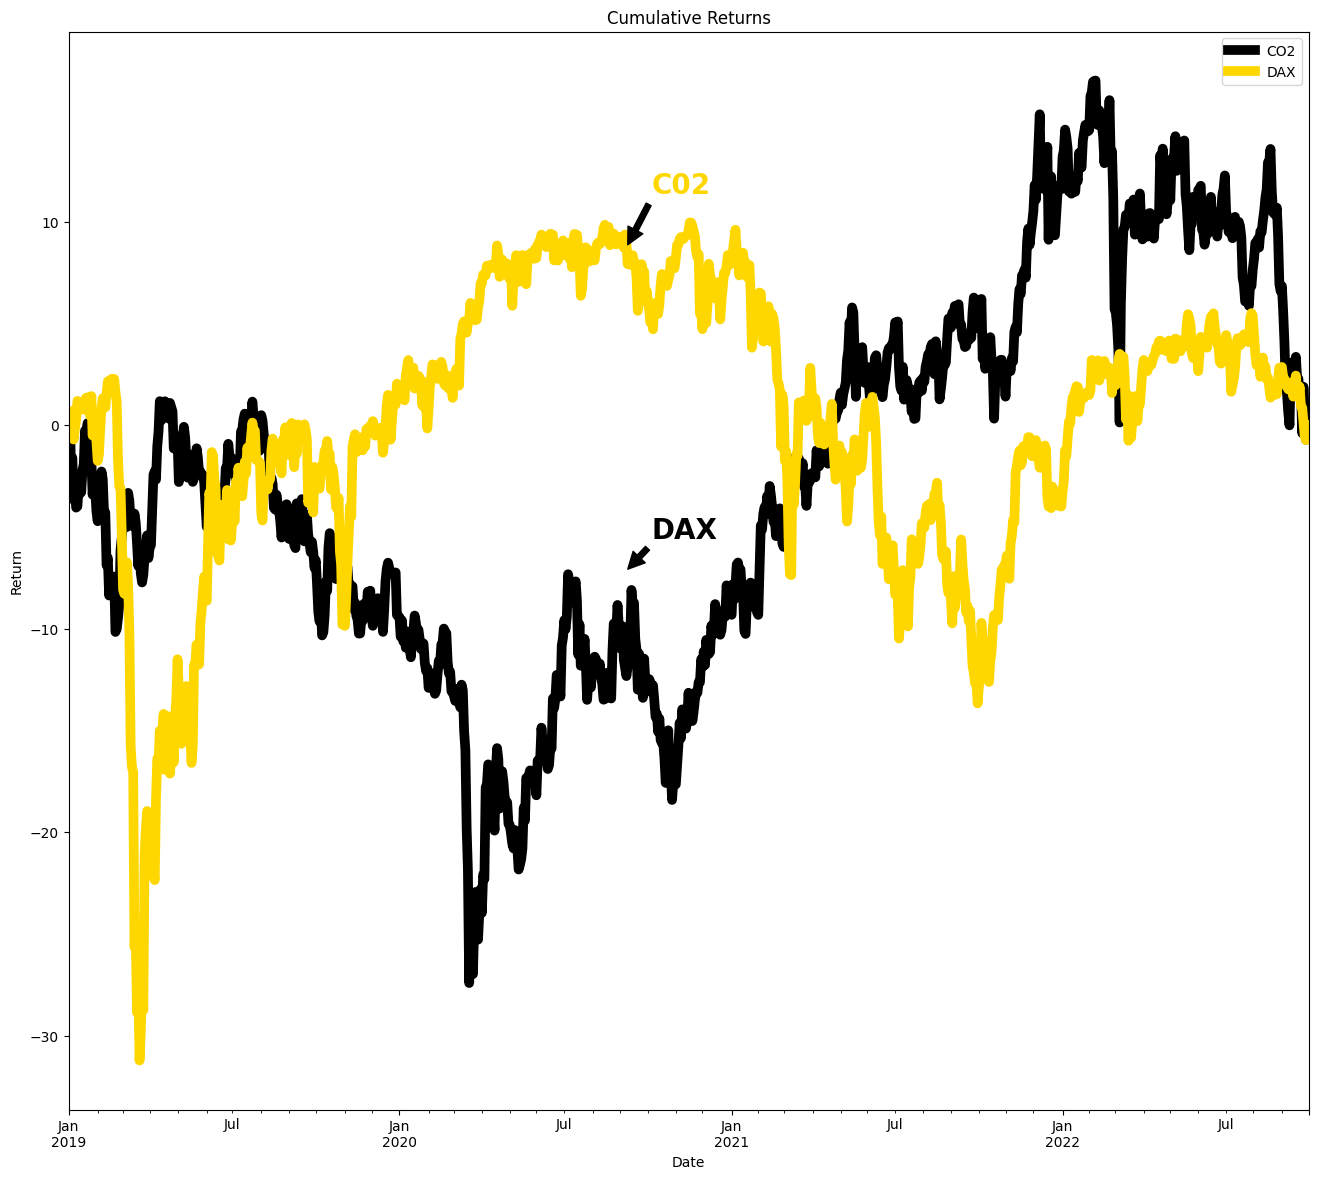

In [14]:
cumulative_returns = data_norm.cumsum()
# Plotting the normalized data
cumulative_returns.plot(figsize=(16, 14), title='Cumulative Returns', xlabel='Date', ylabel='Return', legend=False)


cumulative_returns['CO2'].plot(linewidth=7, color='black', legend=True)

cumulative_returns['DAX'].plot(linewidth=7, color='gold', legend=True)



# Add annotation
plt.annotate('C02', xy=(0.45, 0.8), xycoords='axes fraction',
             xytext=(0.47, 0.85), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=20, color='gold', weight='bold')

# Add annotation
plt.annotate('DAX', xy=(0.45, 0.50), xycoords='axes fraction',
             xytext=(0.47, 0.53), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=20, color='black', weight='bold')


plt.show()
plt.show()

In [15]:
# Calculate basic statistics - mean, max, min, std only
basic_stats = data_ret.describe().loc[['mean', 'max', 'min', 'std']]

In [16]:
basic_stats_T = basic_stats.T

In [17]:
# Compute skewness
skewness = data_ret.skew()

# Compute kurtosis
kurtosis = data_ret.kurtosis()

In [18]:

# Merge skewness to basic_stats_T DataFrame
result_moments = pd.concat([basic_stats_T, skewness, kurtosis], axis=1)

In [19]:
# If you want to rename the new column:
result_moments.rename(columns={0: 'Skewness', 1: 'Kurtosis'}, inplace=True)

In [20]:

# If you want to rename the new column:
result_moments

,mean,max,min,std,Skewness,Kurtosis
CO2,0.001468,0.175760,-0.165022,0.030009,-0.277193,4.010565
DAX,0.000255,0.109759,-0.122386,0.014272,-0.389548,11.852075


## Step 2 b)

In [30]:

def likelihood(xi_prob, mu, sigma, y):
    safe_sigma = np.where(sigma > 0, sigma, 1e-10)  # Avoid zero division
    phi = norm.pdf((y - mu) / safe_sigma)
    y_like = np.dot(xi_prob, phi)
    return y_like

def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))
    safe_sigma = np.where(sigma > 0, sigma, 1e-10)  # Ensure sigma is never zero

    # Initialize the first observation
    y_like = likelihood(pi_hat0, mu, safe_sigma, Y[0])
    phi = norm.pdf((Y[0] - mu) / safe_sigma)
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    # Process subsequent observations
    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, safe_sigma, Y[tt])
        phi = norm.pdf((Y[tt] - mu) / safe_sigma)
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1

def backward_alg(xi_prob_t, xi_prob_t1, N, T, P, mu, sigma, Y):
    xi_prob_T = np.zeros((T, N))
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]

    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T

def M_step_func(xi_prob, P, N, T, Y):
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(N):
        total_prob_ss = np.sum(xi_prob[:, ss])
        total_prob_ss = total_prob_ss if total_prob_ss > 0 else 1e-10  # Avoid division by zero

        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / total_prob_ss

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)

        for ss2 in range(N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(P[ss, :, 1:])

        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat



In [49]:
#to get an idea what starting adjusted means to take
mean_YData = np.mean(YData)
max_YData = np.max(YData)
min_YData = np.min(YData)

print("Mean of YData: ", mean_YData)
print("Max of YData: ", max_YData)
print("Min of YData: ", min_YData)

Mean of YData:  3.641453463442233
Max of YData:  4.580672554387691
Min of YData:  2.7232671669070703


In [47]:
# Initialize parameters
T = len(YData)
N = 3  # Number of states

# Test different initial parameter guesses
mu_hat0 = np.array([2.75, 3.5, 4.6])  # Adjusted means
sigma_hat0 = np.array([0.3, 0.3, 0.3])  # Higher variance for all
P_hat0 = np.array([[0.80, 0.15, 0.05], [0.10, 0.85, 0.05], [0.05, 0.15, 0.80]])
pi_hat0 = np.array([0.4, 0.3, 0.3])  # More balanced initial probabilities

# Convergence criteria
itemax = 200
itetol = 1e-2

<ipython-input-38-0c1df3d33aae>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / total_prob_ss
<ipython-input-38-0c1df3d33aae>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)


Convergence reached.
Final Estimates:
Mu: [3.13344101 3.2975102  4.11845304]
Sigma: [0.10819283 0.04719135 0.31606557]
Transition Matrix: [[9.83735723e-001 1.62642769e-002 7.03940605e-243]
 [2.65992315e-002 9.68193144e-001 5.20762426e-003]
 [5.91369515e-169 7.95326131e-078 1.00000000e+000]]
Initial Probabilities: [1.41864857e-29 1.00000000e+00 0.00000000e+00]


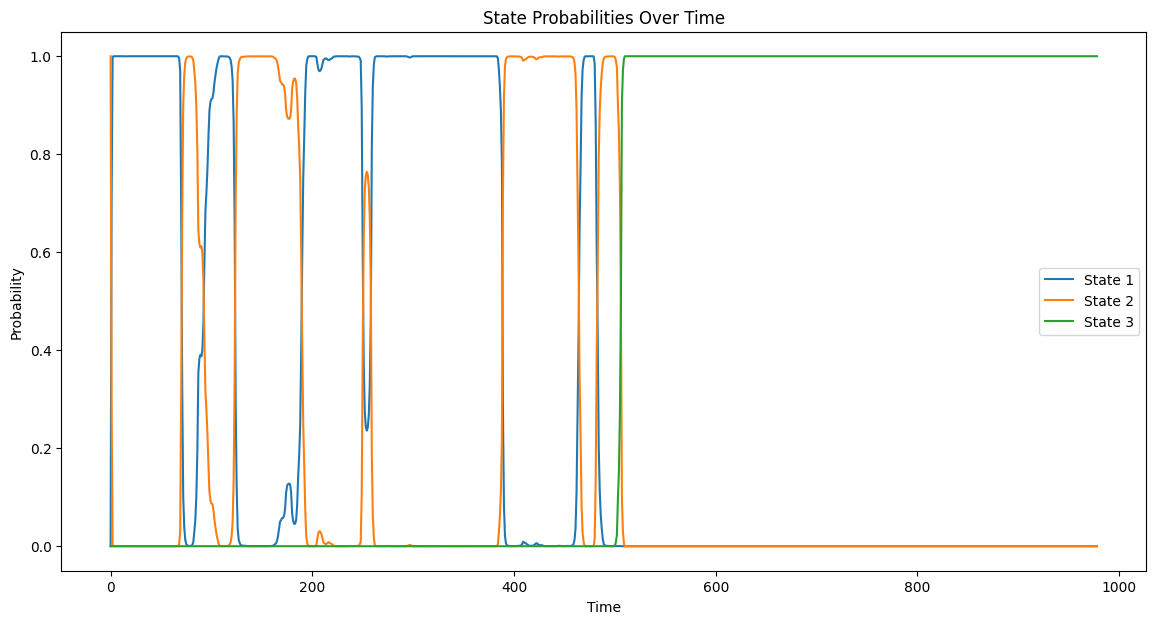

In [48]:
for ite in range(itemax):
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData)

    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(N):
            for ss2 in range(N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]

    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    # Calculate convergence
    mu_diff = np.sum(np.abs(mu_hat1 - mu_hat0))
    sigma_diff = np.sum(np.abs(sigma_hat1 - sigma_hat0))
    P_diff = np.sum(np.abs(P_hat1 - P_hat0))
    pi_diff = np.sum(np.abs(pi_hat1 - pi_hat0))

    if max(mu_diff, sigma_diff, P_diff, pi_diff) < itetol:
        print("Convergence reached.")
        break

    # Update parameters
    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1

print("Final Estimates:")
print("Mu:", mu_hat1)
print("Sigma:", sigma_hat1)
print("Transition Matrix:", P_hat1)
print("Initial Probabilities:", pi_hat1)

# Plot the state probabilities over time
plt.figure(figsize=(14, 7))
plt.plot(xi_prob_T[:, 0], label='State 1')
plt.plot(xi_prob_T[:, 1], label='State 2')
plt.plot(xi_prob_T[:, 2], label='State 3')
plt.title('State Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()


The plot shows that State 1 and State 2 are predominant for most of the time series. State 3, although very stable once entered as indicated by the previous model output, seems to have brief periods of dominance, which are very sharply defined and short-lived.

## Step 3

### Different means

<ipython-input-38-0c1df3d33aae>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / total_prob_ss
<ipython-input-38-0c1df3d33aae>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)


Convergence reached.
Final Estimates:
Mu: [2.95215191 3.4461723  4.42037788]
Sigma: [0.0083139  0.38001847 0.06225105]
Transition Matrix: [[7.33250119e-03 9.92667499e-01 0.00000000e+00]
 [2.91953819e-52 9.97440743e-01 2.55925707e-03]
 [0.00000000e+00 1.01950162e-02 9.89804984e-01]]
Initial Probabilities: [0. 1. 0.]


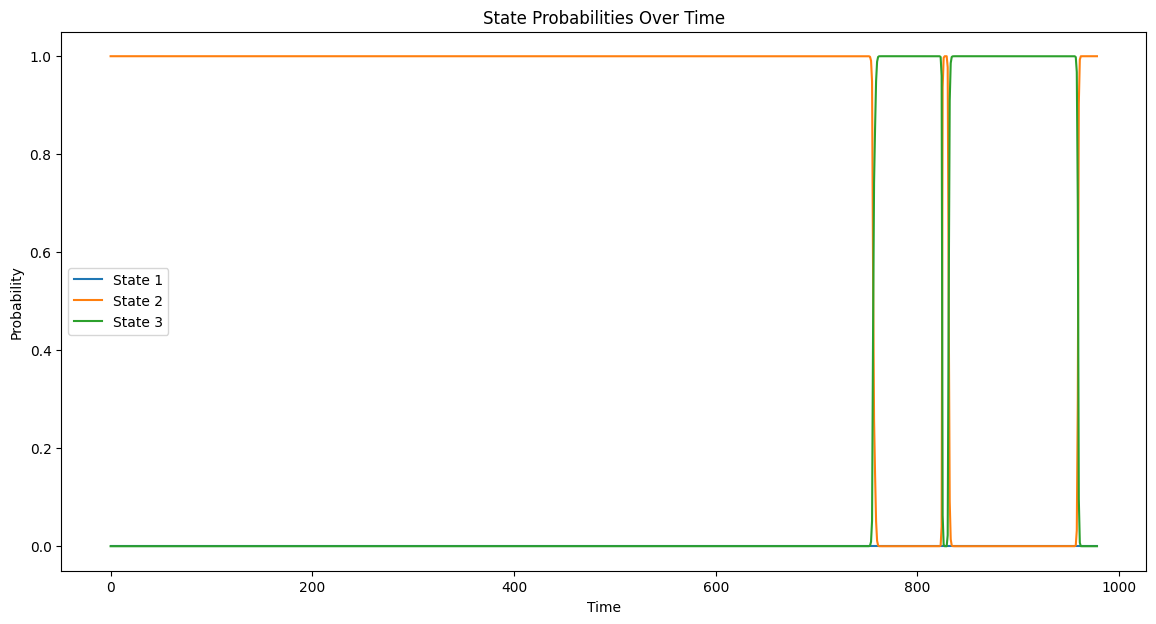

In [54]:
# Initialize parameters
T = len(YData)
N = 3  # Number of states

# Test different initial parameter guesses
mu_hat0 = np.array([2, 4, 5])  # Adjusted means
sigma_hat0 = np.array([0.3, 0.3, 0.3])  # Higher variance for all
P_hat0 = np.array([[0.80, 0.15, 0.05], [0.10, 0.85, 0.05], [0.05, 0.15, 0.80]])
pi_hat0 = np.array([0.4, 0.3, 0.3])  # More balanced initial probabilities

# Convergence criteria
itemax = 200
itetol = 1e-2

for ite in range(itemax):
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData)

    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(N):
            for ss2 in range(N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]

    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    # Calculate convergence
    mu_diff = np.sum(np.abs(mu_hat1 - mu_hat0))
    sigma_diff = np.sum(np.abs(sigma_hat1 - sigma_hat0))
    P_diff = np.sum(np.abs(P_hat1 - P_hat0))
    pi_diff = np.sum(np.abs(pi_hat1 - pi_hat0))

    if max(mu_diff, sigma_diff, P_diff, pi_diff) < itetol:
        print("Convergence reached.")
        break

    # Update parameters
    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1

print("Final Estimates:")
print("Mu:", mu_hat1)
print("Sigma:", sigma_hat1)
print("Transition Matrix:", P_hat1)
print("Initial Probabilities:", pi_hat1)

# Plot the state probabilities over time
plt.figure(figsize=(14, 7))
plt.plot(xi_prob_T[:, 0], label='State 1')
plt.plot(xi_prob_T[:, 1], label='State 2')
plt.plot(xi_prob_T[:, 2], label='State 3')
plt.title('State Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [56]:
log_likelihood = np.sum(np.log(np.array([likelihood(pi_hat0, mu_hat0, sigma_hat0, y) for y in YData])))
num_params = 2 * N + (N**2 - N)

num_samples = T

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = np.log(num_samples) * num_params - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: 3900.9921894326144
BIC: 3959.6305691429807


More extreme adjusted means leads to overdominance of 2 states and brisk changes between them

<ipython-input-38-0c1df3d33aae>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / total_prob_ss
<ipython-input-38-0c1df3d33aae>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)


Convergence reached.
Final Estimates:
Mu: [3.13423128 3.29807833 4.11854087]
Sigma: [0.10826633 0.04713706 0.3159843 ]
Transition Matrix: [[9.83893841e-001 1.61061591e-002 3.59221372e-103]
 [2.68123128e-002 9.67922793e-001 5.26489407e-003]
 [2.12213828e-091 7.10823988e-069 1.00000000e+000]]
Initial Probabilities: [1.21687042e-44 1.00000000e+00 0.00000000e+00]


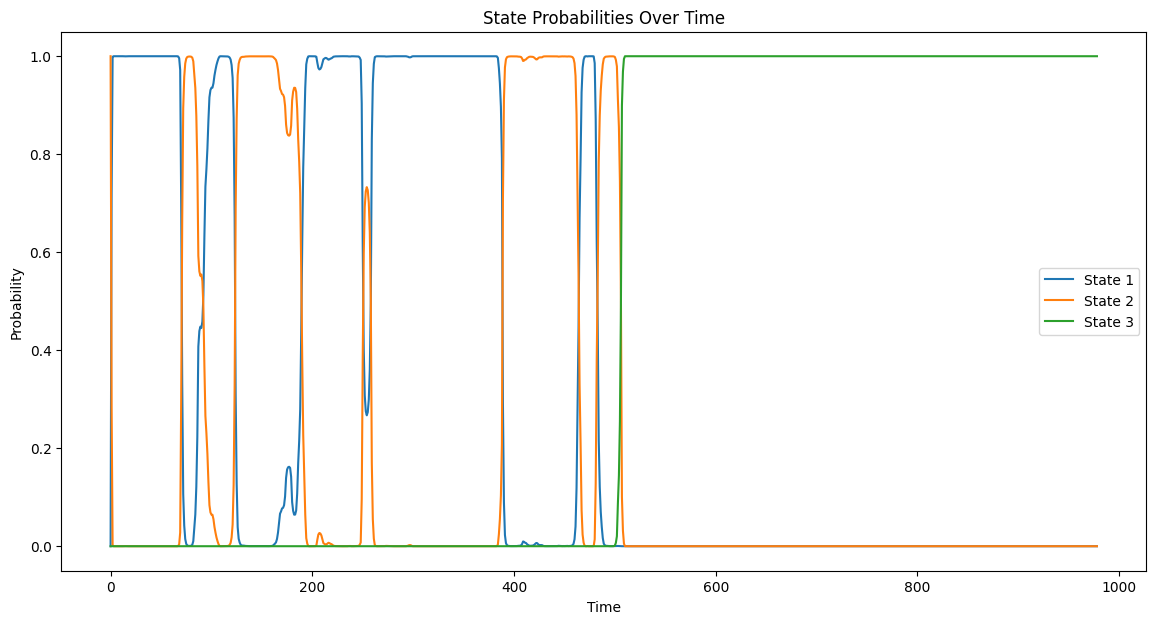

In [52]:
# Initialize parameters
T = len(YData)
N = 3  # Number of states

# Test different initial parameter guesses
mu_hat0 = np.array([2, 3, 4])  # Adjusted means
sigma_hat0 = np.array([0.3, 0.3, 0.3])  # Higher variance for all
P_hat0 = np.array([[0.80, 0.15, 0.05], [0.10, 0.85, 0.05], [0.05, 0.15, 0.80]])
pi_hat0 = np.array([0.4, 0.3, 0.3])  # More balanced initial probabilities

# Convergence criteria
itemax = 200
itetol = 1e-2

for ite in range(itemax):
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData)

    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(N):
            for ss2 in range(N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]

    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    # Calculate convergence
    mu_diff = np.sum(np.abs(mu_hat1 - mu_hat0))
    sigma_diff = np.sum(np.abs(sigma_hat1 - sigma_hat0))
    P_diff = np.sum(np.abs(P_hat1 - P_hat0))
    pi_diff = np.sum(np.abs(pi_hat1 - pi_hat0))

    if max(mu_diff, sigma_diff, P_diff, pi_diff) < itetol:
        print("Convergence reached.")
        break

    # Update parameters
    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1

print("Final Estimates:")
print("Mu:", mu_hat1)
print("Sigma:", sigma_hat1)
print("Transition Matrix:", P_hat1)
print("Initial Probabilities:", pi_hat1)

# Plot the state probabilities over time
plt.figure(figsize=(14, 7))
plt.plot(xi_prob_T[:, 0], label='State 1')
plt.plot(xi_prob_T[:, 1], label='State 2')
plt.plot(xi_prob_T[:, 2], label='State 3')
plt.title('State Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [53]:
log_likelihood = np.sum(np.log(np.array([likelihood(pi_hat0, mu_hat0, sigma_hat0, y) for y in YData])))

num_params = 2 * N + (N**2 - N)

num_samples = T

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = np.log(num_samples) * num_params - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: 127055.05957816105
BIC: 127113.69795787141


This is much better result. The closer we are to the means of the regimes, the higher the AIC.

### different sigma values.

<ipython-input-38-0c1df3d33aae>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / total_prob_ss
<ipython-input-38-0c1df3d33aae>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)


Convergence reached.
Final Estimates:
Mu: [2.99478709 3.46378302 4.42057869]
Sigma: [0.04395565 0.37682664 0.06208374]
Transition Matrix: [[9.60739730e-001 3.92602698e-002 3.48257303e-250]
 [1.50331116e-003 9.95840435e-001 2.65625420e-003]
 [5.85434421e-261 1.02114398e-002 9.89788560e-001]]
Initial Probabilities: [8.039102e-18 1.000000e+00 0.000000e+00]


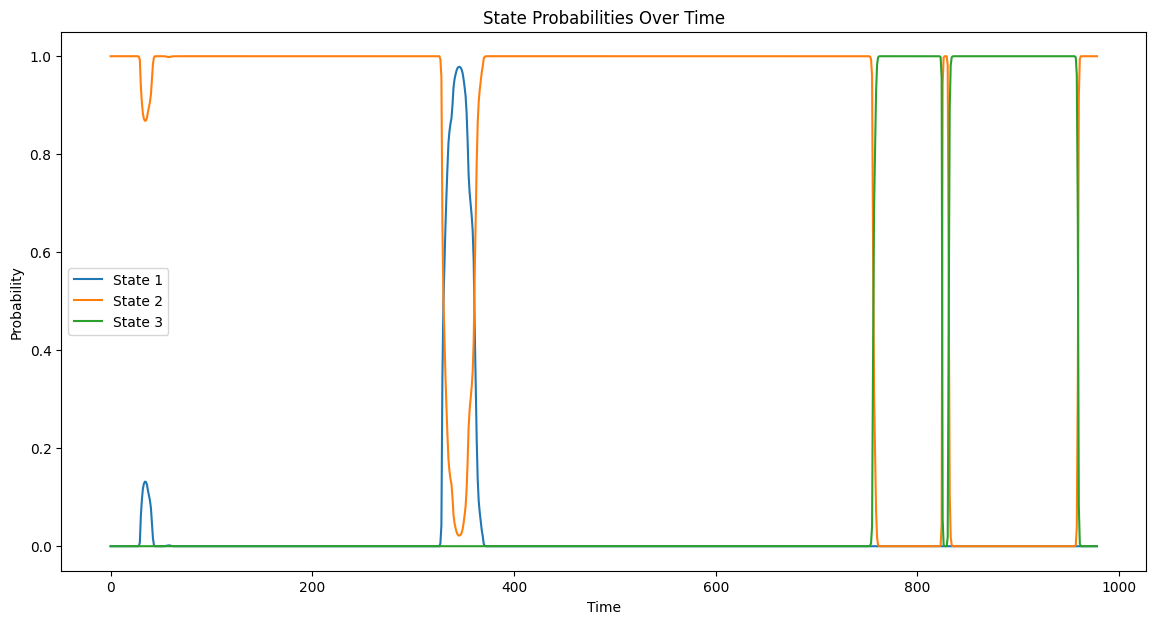

In [58]:

# Test different initial parameter guesses
mu_hat0 = np.array([2.75, 3.5, 4.6])  # Adjusted means
sigma_hat0 = np.array([0.3, 1.2, 0.3])  # Higher variance the extreme case
P_hat0 = np.array([[0.80, 0.15, 0.05], [0.10, 0.85, 0.05], [0.05, 0.15, 0.80]])
pi_hat0 = np.array([0.4, 0.3, 0.3])  # More balanced initial probabilities


for ite in range(itemax):
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData)

    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(N):
            for ss2 in range(N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]

    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    # Calculate convergence
    mu_diff = np.sum(np.abs(mu_hat1 - mu_hat0))
    sigma_diff = np.sum(np.abs(sigma_hat1 - sigma_hat0))
    P_diff = np.sum(np.abs(P_hat1 - P_hat0))
    pi_diff = np.sum(np.abs(pi_hat1 - pi_hat0))

    if max(mu_diff, sigma_diff, P_diff, pi_diff) < itetol:
        print("Convergence reached.")
        break

    # Update parameters
    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1

print("Final Estimates:")
print("Mu:", mu_hat1)
print("Sigma:", sigma_hat1)
print("Transition Matrix:", P_hat1)
print("Initial Probabilities:", pi_hat1)

# Plot the state probabilities over time
plt.figure(figsize=(14, 7))
plt.plot(xi_prob_T[:, 0], label='State 1')
plt.plot(xi_prob_T[:, 1], label='State 2')
plt.plot(xi_prob_T[:, 2], label='State 3')
plt.title('State Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [59]:
log_likelihood = np.sum(np.log(np.array([likelihood(pi_hat0, mu_hat0, sigma_hat0, y) for y in YData])))

num_params = 2 * N + (N**2 - N)

num_samples = T

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = np.log(num_samples) * num_params - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: 3887.4412622178693
BIC: 3946.0796419282356


<ipython-input-38-0c1df3d33aae>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / total_prob_ss
<ipython-input-38-0c1df3d33aae>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = np.sqrt(xi_y_mu2 / total_prob_ss)


Convergence reached.
Final Estimates:
Mu: [3.14863065 3.31130172 4.119684  ]
Sigma: [0.10914595 0.04484401 0.31493175]
Transition Matrix: [[9.87675155e-01 1.23248446e-02 1.37615999e-77]
 [2.32086078e-02 9.70019557e-01 6.77183514e-03]
 [3.65747500e-95 2.98939094e-67 1.00000000e+00]]
Initial Probabilities: [9.99999966e-01 3.42440541e-08 0.00000000e+00]


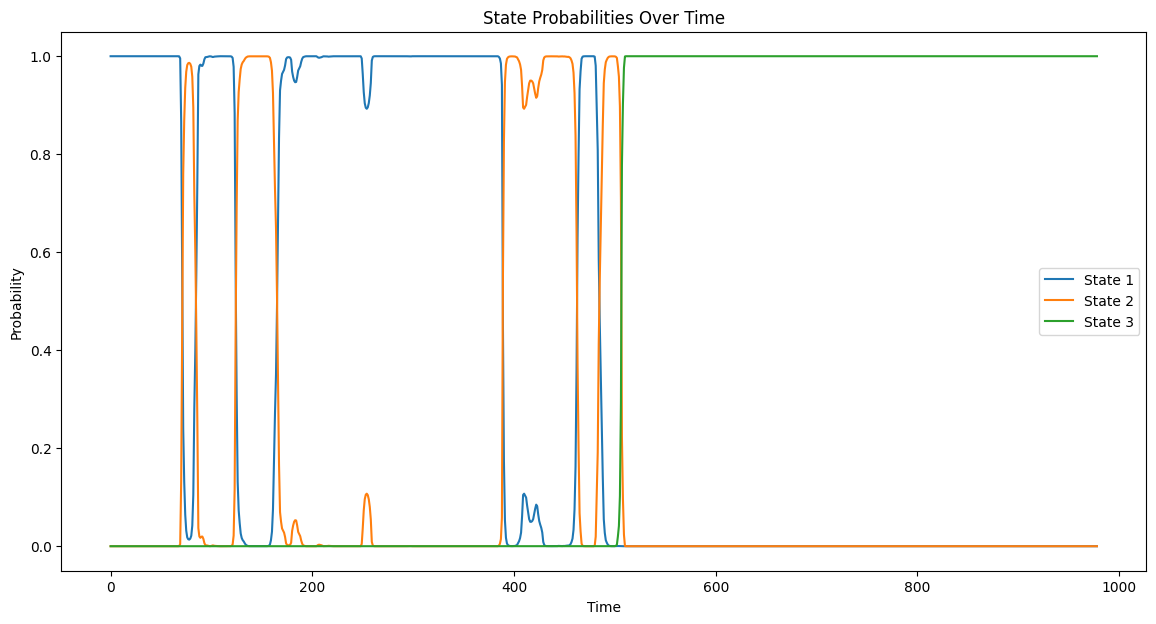

In [60]:
# Test different initial parameter guesses
mu_hat0 = np.array([2.75, 3.5, 4.6])  # Adjusted means
sigma_hat0 = np.array([0.2, 0.5, 1.0])   # increasing vola with state
P_hat0 = np.array([[0.80, 0.15, 0.05], [0.10, 0.85, 0.05], [0.05, 0.15, 0.80]])
pi_hat0 = np.array([0.4, 0.3, 0.3])  # More balanced initial probabilities


for ite in range(itemax):
    xi_prob_t, xi_prob_t1 = forward_alg(pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, YData)
    xi_prob_T = backward_alg(xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, YData)

    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(N):
            for ss2 in range(N):
                P_hat_T[ss, ss2, tt] = P_hat0[ss, ss2] * xi_prob_t[tt - 1, ss] * xi_prob_T[tt, ss2] / xi_prob_t1[tt - 1, ss2]

    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, YData)

    # Calculate convergence
    mu_diff = np.sum(np.abs(mu_hat1 - mu_hat0))
    sigma_diff = np.sum(np.abs(sigma_hat1 - sigma_hat0))
    P_diff = np.sum(np.abs(P_hat1 - P_hat0))
    pi_diff = np.sum(np.abs(pi_hat1 - pi_hat0))

    if max(mu_diff, sigma_diff, P_diff, pi_diff) < itetol:
        print("Convergence reached.")
        break

    # Update parameters
    mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1

print("Final Estimates:")
print("Mu:", mu_hat1)
print("Sigma:", sigma_hat1)
print("Transition Matrix:", P_hat1)
print("Initial Probabilities:", pi_hat1)

# Plot the state probabilities over time
plt.figure(figsize=(14, 7))
plt.plot(xi_prob_T[:, 0], label='State 1')
plt.plot(xi_prob_T[:, 1], label='State 2')
plt.plot(xi_prob_T[:, 2], label='State 3')
plt.title('State Probabilities Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [61]:
log_likelihood = np.sum(np.log(np.array([likelihood(pi_hat0, mu_hat0, sigma_hat0, y) for y in YData])))

num_params = 2 * N + (N**2 - N)

num_samples = T

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = np.log(num_samples) * num_params - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)


AIC: 44340.4949067755
BIC: 44399.13328648586


Gradual vola increase instead of sharp increase leads to better models